# Harry potter discovery
#### Progetto per l'insegnamento di Data Analytics dell'anno accademico 2024/2025.
#### Componenti: Alessia Novacco 918850, Nicolò Sansevrino 865889

Il progetto verte su ....

In [366]:
import kagglehub
import pandas as pd
import re
import csv
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [367]:
characters = pd.read_csv("Harry_Potter_Movies/Characters.csv", encoding='latin-1')
characters.head()

Character ID    Character Name                Species  Gender       House  \
0             1      Harry Potter                  Human    Male  Gryffindor   
1             2       Ron Weasley                  Human    Male  Gryffindor   
2             3  Hermione Granger                  Human  Female  Gryffindor   
3             4  Albus Dumbledore                  Human    Male  Gryffindor   
4             5     Rubeus Hagrid  Half-Human/Half-Giant    Male  Gryffindor   

               Patronus Wand (Wood)         Wand (Core)  
0                  Stag       Holly     Phoenix Feather  
1  Jack Russell Terrier         NaN                 NaN  
2                 Otter        Vine  Dragon Heartstring  
3               Phoenix       Elder  Thestral Tail Hair  
4                   NaN         Oak                 NaN

In [368]:
movies = pd.read_csv("Harry_Potter_Movies/Movies.csv", encoding="utf-8-sig")
movies.head(9)

Movie ID                                  Movie Title  Release Year  \
0         1     Harry Potter and the Philosopher's Stone          2001   
1         2      Harry Potter and the Chamber of Secrets          2002   
2         3     Harry Potter and the Prisoner of Azkaban          2004   
3         4          Harry Potter and the Goblet of Fire          2005   
4         5    Harry Potter and the Order of the Phoenix          2007   
5         6       Harry Potter and the Half-Blood Prince          2009   
6         7  Harry Potter and the Deathly Hallows Part 1          2010   
7         8  Harry Potter and the Deathly Hallows Part 2          2011   

   Runtime         Budget       Box Office  
0      152  $125,000,000   $1,002,000,000   
1      161  $100,000,000     $880,300,000   
2      142  $130,000,000     $796,700,000   
3      157  $150,000,000     $896,400,000   
4      138  $150,000,000     $942,000,000   
5      153  $250,000,000     $943,200,000   
6      146  $200,000,000     $976,900,000   
7      130  $250,000,000   $1,342,000,000

In [369]:
dialogues = pd.read_csv("Harry_Potter_Movies/Dialogue.csv", encoding='latin-1')
dialogues.head()

Dialogue ID  Chapter ID  Place ID  Character ID  \
0            1           1         8             4   
1            2           1         8             7   
2            3           1         8             4   
3            4           1         8             7   
4            5           1         8             4   

                                            Dialogue  
0  I should have known that you would be here...P...  
1  Good evening, Professor Dumbledore. Are the ru...  
2   I'm afraid so, Professor. The good, and the bad.  
3                                       And the boy?  
4                            Hagrid is bringing him.

In [370]:
chapters = pd.read_csv("Harry_Potter_Movies/Chapters.csv", encoding='latin-1')
chapters.head()

Chapter ID         Chapter Name  Movie ID  Movie Chapter
0           1    Doorstep Delivery         1              1
1           2  The Vanishing Glass         1              2
2           3  Letters from No One         1              3
3           4   Keeper of the Keys         1              4
4           5         Diagon Alley         1              5

In [371]:
dialogs = dialogues.merge(chapters[["Chapter ID", "Movie ID"]], on="Chapter ID")
dialogs = dialogs.sort_values(by=["Movie ID", "Chapter ID", "Dialogue ID"])
dialogs.head()

Dialogue ID  Chapter ID  Place ID  Character ID  \
0            1           1         8             4   
1            2           1         8             7   
2            3           1         8             4   
3            4           1         8             7   
4            5           1         8             4   

                                            Dialogue  Movie ID  
0  I should have known that you would be here...P...         1  
1  Good evening, Professor Dumbledore. Are the ru...         1  
2   I'm afraid so, Professor. The good, and the bad.         1  
3                                       And the boy?         1  
4                            Hagrid is bringing him.         1

In [372]:
# Aggiungi Character Name
dialogs = dialogs.merge(characters[["Character ID", "Character Name"]], on="Character ID")
dialogs["speaker"] = dialogs["Character Name"].str.lower().str.strip()
dialogs.head()

Dialogue ID  Chapter ID  Place ID  Character ID  \
0            1           1         8             4   
1            2           1         8             7   
2            3           1         8             4   
3            4           1         8             7   
4            5           1         8             4   

                                            Dialogue  Movie ID  \
0  I should have known that you would be here...P...         1   
1  Good evening, Professor Dumbledore. Are the ru...         1   
2   I'm afraid so, Professor. The good, and the bad.         1   
3                                       And the boy?         1   
4                            Hagrid is bringing him.         1   

       Character Name             speaker  
0    Albus Dumbledore    albus dumbledore  
1  Minerva McGonagall  minerva mcgonagall  
2    Albus Dumbledore    albus dumbledore  
3  Minerva McGonagall  minerva mcgonagall  
4    Albus Dumbledore    albus dumbledore

In [373]:
graphs = {}  # film_id → grafo
centrality_results = {}  # film_id → df con centralità

for mid, g in dialogs.groupby("Movie ID"):

    G = nx.DiGraph()

    # Lista dei turni parlati
    speakers = g["Character Name"].tolist()

    # Costruisci coppie consecutive A→B
    pairs = [(a, b) for a, b in zip(speakers[:-1], speakers[1:]) if a != b]

    # Conta interazioni tra ogni coppia
    interaction_count = defaultdict(int)
    interlocutors = defaultdict(set)

    for a, b in pairs:
        interaction_count[(a, b)] += 1
        interlocutors[a].add(b)

    max_count = max(interaction_count.values())

    # Calcola somma delle interazioni per ogni A (normalizzazione per A)
    for (a, b), count in interaction_count.items():
        norm_weight = count / max_count
        G.add_edge(a, b, weight=norm_weight)


    graphs[mid] = G

    betweenness = nx.betweenness_centrality(G, weight="weight")

    #  Calcolo degree centrality su grafo non orientato temporaneo
    G_undirected = G.to_undirected()
    degree = nx.degree_centrality(G_undirected)

    # Crea DataFrame centralità
    df_centrality = pd.DataFrame({
        'Character Name': list(betweenness.keys()),
        'Betweenness': [betweenness[k] for k in betweenness.keys()],
        'Centrality': [degree[k] for k in betweenness.keys()],
        'Movie ID': mid
    })

    centrality_results[mid] = df_centrality

    # OUTPUT DI CONTROLLO
    print(f"Movie ID {mid} - Nodi: {G.number_of_nodes()}, Archi: {G.number_of_edges()}")
    display(df_centrality.sort_values("Betweenness", ascending=False).head(10))

    centrality_all = pd.concat(centrality_results, ignore_index=True)

    # Elimina le colonne che causano conflitto PRIMA del merge
    dialogs = dialogs.drop(columns=['Centrality', 'Betweenness'], errors='ignore')

    # Ora puoi eseguire il merge tranquillamente
    dialogs = dialogs.merge(centrality_all, on=['Movie ID', 'Character Name'], how='left')

Movie ID 1 - Nodi: 50, Archi: 231


Character Name  Betweenness  Centrality  Movie ID
6         Harry Potter     0.345273    0.734694         1
2        Rubeus Hagrid     0.224328    0.408163         1
21         Ron Weasley     0.168609    0.408163         1
43          Lee Jordan     0.152056    0.163265         1
23    Hermione Granger     0.136764    0.346939         1
31                Girl     0.127722    0.204082         1
12                 Boy     0.089449    0.163265         1
1   Minerva McGonagall     0.081923    0.285714         1
39         Argus Filch     0.073772    0.142857         1
0     Albus Dumbledore     0.070910    0.183673         1

Movie ID 2 - Nodi: 51, Archi: 257


Character Name  Betweenness  Centrality  Movie ID
0        Harry Potter     0.269975        0.66         2
5         Ron Weasley     0.269841        0.56         2
17  Gilderoy Lockhart     0.161372        0.34         2
15   Hermione Granger     0.151411        0.40         2
18       Draco Malfoy     0.123738        0.32         2
12              Other     0.111129        0.18         2
26      Pomona Sprout     0.102159        0.12         2
23      Severus Snape     0.075395        0.18         2
3      Dudley Dursley     0.069154        0.10         2
24   Albus Dumbledore     0.058013        0.28         2

Movie ID 3 - Nodi: 40, Archi: 199


Character Name  Betweenness  Centrality  Movie ID
0         Harry Potter     0.423789    0.692308         3
10    Hermione Granger     0.213452    0.461538         3
9          Ron Weasley     0.190757    0.564103         3
15         Remus Lupin     0.177055    0.384615         3
5        Station guard     0.105376    0.153846         3
1      Petunia Dursley     0.101215    0.076923         3
18     Seamus Finnigan     0.100300    0.179487         3
22               Other     0.095143    0.153846         3
28  Minerva McGonagall     0.093893    0.179487         3
16    Albus Dumbledore     0.091835    0.282051         3

Movie ID 4 - Nodi: 42, Archi: 210


Character Name  Betweenness  Centrality  Movie ID
6        Ron Weasley     0.258927    0.585366         4
20  Albus Dumbledore     0.195132    0.560976         4
5       Harry Potter     0.186197    0.682927         4
2          Voldemort     0.163723    0.243902         4
4   Hermione Granger     0.149067    0.414634         4
25     Alastor Moody     0.100011    0.341463         4
7     Arthur Weasley     0.088247    0.219512         4
11    George Weasley     0.065843    0.243902         4
9     Cedric Diggory     0.060709    0.170732         4
13      Draco Malfoy     0.049648    0.097561         4

Movie ID 5 - Nodi: 63, Archi: 256


Character Name  Betweenness  Centrality  Movie ID
2         Harry Potter     0.464645    0.741935         5
15    Hermione Granger     0.325014    0.370968         5
13        Sirius Black     0.159455    0.225806         5
23    Dolores Umbridge     0.110903    0.241935         5
31  Minerva McGonagall     0.107407    0.129032         5
21    Albus Dumbledore     0.105764    0.209677         5
60              Ghosts     0.097756    0.080645         5
25        Fred Weasley     0.083263    0.129032         5
45        Draco Malfoy     0.081315    0.080645         5
16         Ron Weasley     0.079797    0.209677         5

Movie ID 6 - Nodi: 39, Archi: 185


Character Name  Betweenness  Centrality  Movie ID
10    Hermione Granger     0.299548    0.473684         6
4         Harry Potter     0.235784    0.631579         6
7        Ginny Weasley     0.202361    0.394737         6
15        Draco Malfoy     0.172478    0.315789         6
9          Ron Weasley     0.169443    0.447368         6
5     Albus Dumbledore     0.160812    0.315789         6
6      Horace Slughorn     0.144337    0.421053         6
14       Luna Lovegood     0.094123    0.184211         6
20  Minerva McGonagall     0.073735    0.210526         6
28  Neville Longbottom     0.073709    0.131579         6

Movie ID 7 - Nodi: 57, Archi: 233


Character Name  Betweenness  Centrality  Movie ID
17          Harry Potter     0.343468    0.607143         7
2       Hermione Granger     0.310606    0.410714         7
6              Voldemort     0.248505    0.285714         7
27           Remus Lupin     0.125322    0.250000         7
4            Ron Weasley     0.117326    0.392857         7
13   Bellatrix Lestrange     0.103107    0.196429         7
42                 Dobby     0.097935    0.142857         7
12       Pius Thicknesse     0.083927    0.089286         7
21         Alastor Moody     0.077948    0.142857         7
22  Kingsley Shacklebolt     0.075979    0.107143         7

Movie ID 8 - Nodi: 50, Archi: 173


Character Name  Betweenness  Centrality  Movie ID
2          Harry Potter     0.537508    0.673469         8
4           Ron Weasley     0.229746    0.346939         8
19        Ginny Weasley     0.206786    0.244898         8
11            Voldemort     0.194696    0.285714         8
15      Seamus Finnigan     0.158539    0.102041         8
5      Hermione Granger     0.140211    0.285714         8
8   Bellatrix Lestrange     0.089531    0.183673         8
21        Severus Snape     0.080272    0.163265         8
36     Sybill Trelawney     0.064413    0.061224         8
14   Neville Longbottom     0.055127    0.204082         8

In [374]:
# Usa pesi per le centralità
degree_c = nx.degree_centrality(G)  # NON usa pesi (opzionale)
in_deg   = G.in_degree(weight="weight")
out_deg  = G.out_degree(weight="weight")
pagerank = nx.pagerank(G, weight="weight")

df_c = pd.DataFrame({
    "character": list(G.nodes),
    "in_degree": [in_deg[n] for n in G.nodes],
    "out_degree": [out_deg[n] for n in G.nodes],
    "pagerank": [pagerank[n] for n in G.nodes],
    "raw_degree": [degree_c[n] for n in G.nodes],
    "movie_id": mid
})

centrality_results[mid] = df_c

In [375]:
centrality_df = pd.concat(centrality_results.values(), ignore_index=True)

In [376]:
# Funzione per disegnare il grafo di un tuo film reale
def draw_film_graph_real(G, cut_threshold, pagerank=None, title="Grafo delle interazioni normalizzate tra personaggi"):
    # stampiamo il pesoo degli archi in ordine decrescente
    '''print("Edge weights (sorted):")
    edge_weights = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
    for u, v, d in edge_weights:
        print(f"{u} → {v}: {d['weight']:.2f}")'''

    if pagerank is None:
        pagerank = nx.pagerank(G, weight='weight')

    pos = nx.spring_layout(G, seed=42, k=0.6)
    fig, ax = plt.subplots(figsize=(14, 10))


    node_sizes = [15000 * pagerank[n] for n in G.nodes()]
    edge_sizes = [20 * G[u][v]['weight'] for u, v in G.edges()]
    # impostiamo una edge size massima per evitare che le linee siano troppo spesse
    max_edge_size = 2
    edge_sizes = [min(size, max_edge_size) for size in edge_sizes]
    # Normalizziamo i colori dei nodi in base al pagerank
    node_colors = [pagerank[n] for n in G.nodes()]
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)} # pesi delle interazioni, per ora le conserviamo e basta
    # creiamo degli alfa per gli archi variabili in base al peso dell'arco in modo che siano =0.2 se il loro peso è sotto il threshold, altrimenti =1

    edge_alphas = [0.2 if G[u][v]['weight'] < cut_threshold else 1 for u, v in G.edges()]

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.plasma, alpha=0.9, edgecolors='black', ax=ax)
    nx.draw_networkx_edges(G, pos, width=edge_sizes, alpha=edge_alphas, arrows=True, edge_color='#012201', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='black', ax=ax)
    #nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=8, ax=ax)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Pagerank")

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # mostriamo edge_labels_df in ordine decrescente per peso
    edge_labels_df = pd.DataFrame(edge_labels.items(), columns=['Edge', 'Weight'])
    edge_labels_df = edge_labels_df.sort_values(by='Weight', ascending=False)
    #print("Edge labels (sorted by weight):")
    #print(edge_labels_df.head(10))


In [377]:

def draw_heatmap(adj_matrix, cut_threshold):
  plt.figure(figsize=(12, 10))
  mask = adj_matrix <= cut_threshold
  ax = sns.heatmap(adj_matrix, cmap="YlOrRd", linewidths=0.5, linecolor='gray', mask=mask, cbar=True)

  plt.title("Heatmap delle interazioni tra personaggi")
  plt.xlabel("Personaggio")
  plt.ylabel("Personaggio")

  # grassetto per nomi asse X
  for i, label in enumerate(ax.get_xticklabels()):
      name = adj_matrix.columns[i]
      if (adj_matrix.iloc[:, i] > cut_threshold).any():
          label.set_fontweight('bold')
      label.set_text(name)
      label.set_rotation(90)

  # grassetto per nomi asse Y
  for i, label in enumerate(ax.get_yticklabels()):
      name = adj_matrix.index[i]
      if (adj_matrix.iloc[i, :] > cut_threshold).any():
          label.set_fontweight('bold')
      label.set_text(name)
      label.set_rotation(0)

  # Aggiunta bordi spessi per celle con valore > cut_threshold
  for i in range(adj_matrix.shape[0]):
      for j in range(adj_matrix.shape[1]):
          value = adj_matrix.iloc[i, j]
          if value > cut_threshold:
              # disegna un rettangolo con bordo spesso intorno alla cella
              ax.add_patch(plt.Rectangle(
                  (j, i), 1, 1, fill=False, edgecolor='black', lw=1))

  ax.set_xticklabels(ax.get_xticklabels())
  ax.set_yticklabels(ax.get_yticklabels())

  plt.tight_layout()
  plt.show()


In [378]:
def study_film(film_id, threshold):
  G = graphs[film_id]
  pagerank = nx.pagerank(G, weight="weight")  

  draw_film_graph_real(G, threshold, pagerank, title=f"Grafo delle interazioni normalizzate - Film {film_id}")

  betweenness = nx.betweenness_centrality(G, weight='weight')
  degree = nx.degree_centrality(G)

  adj_matrix = nx.to_pandas_adjacency(G, weight='weight')

  centrality_df = pd.DataFrame({
      "Character Name": list(G.nodes()),
      "Betweenness": [betweenness[n] for n in G.nodes()],
      "Degree": [degree[n] for n in G.nodes()]
  })

  draw_heatmap(adj_matrix, threshold)
  #print(centrality_df)

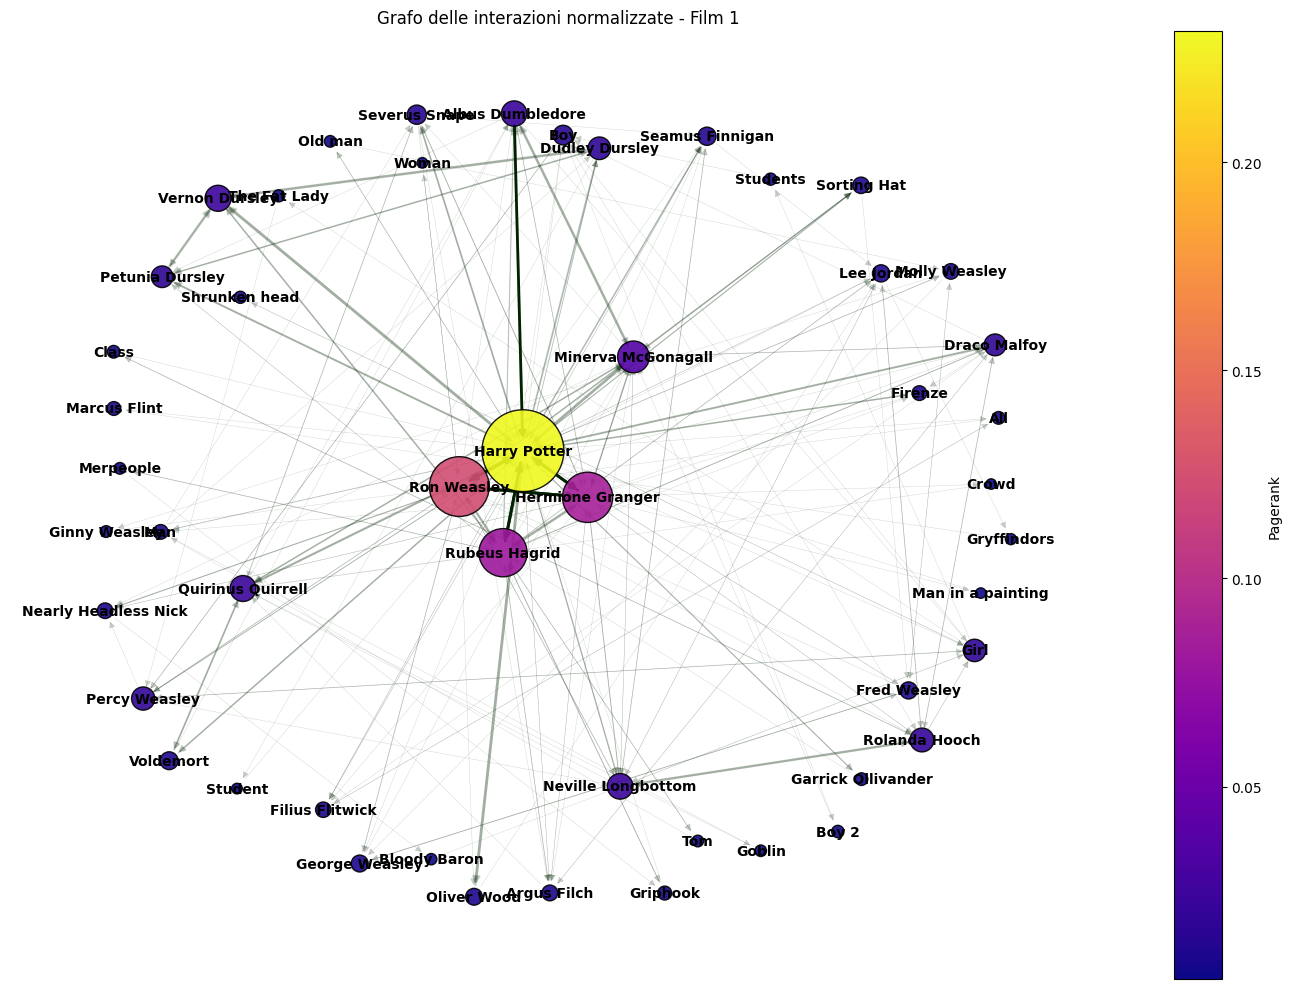

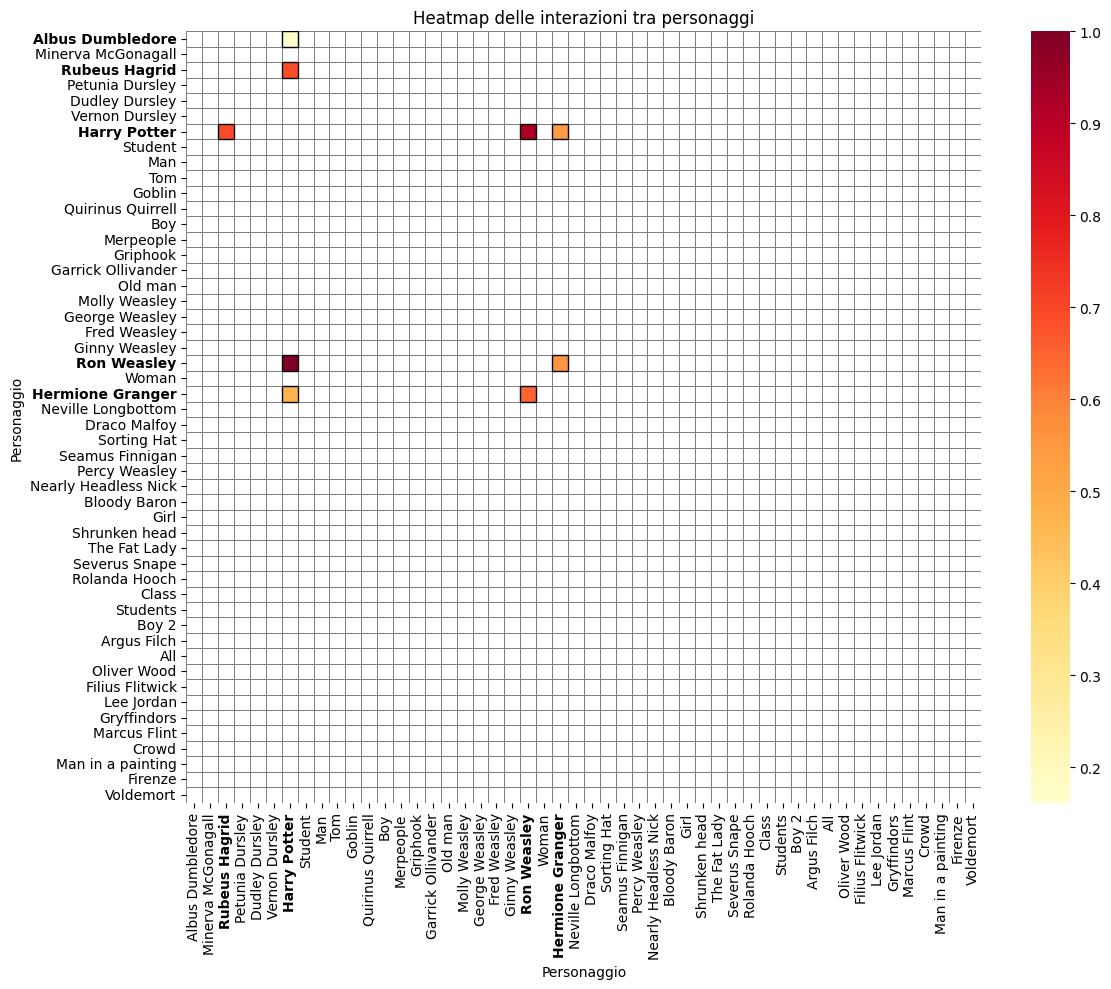

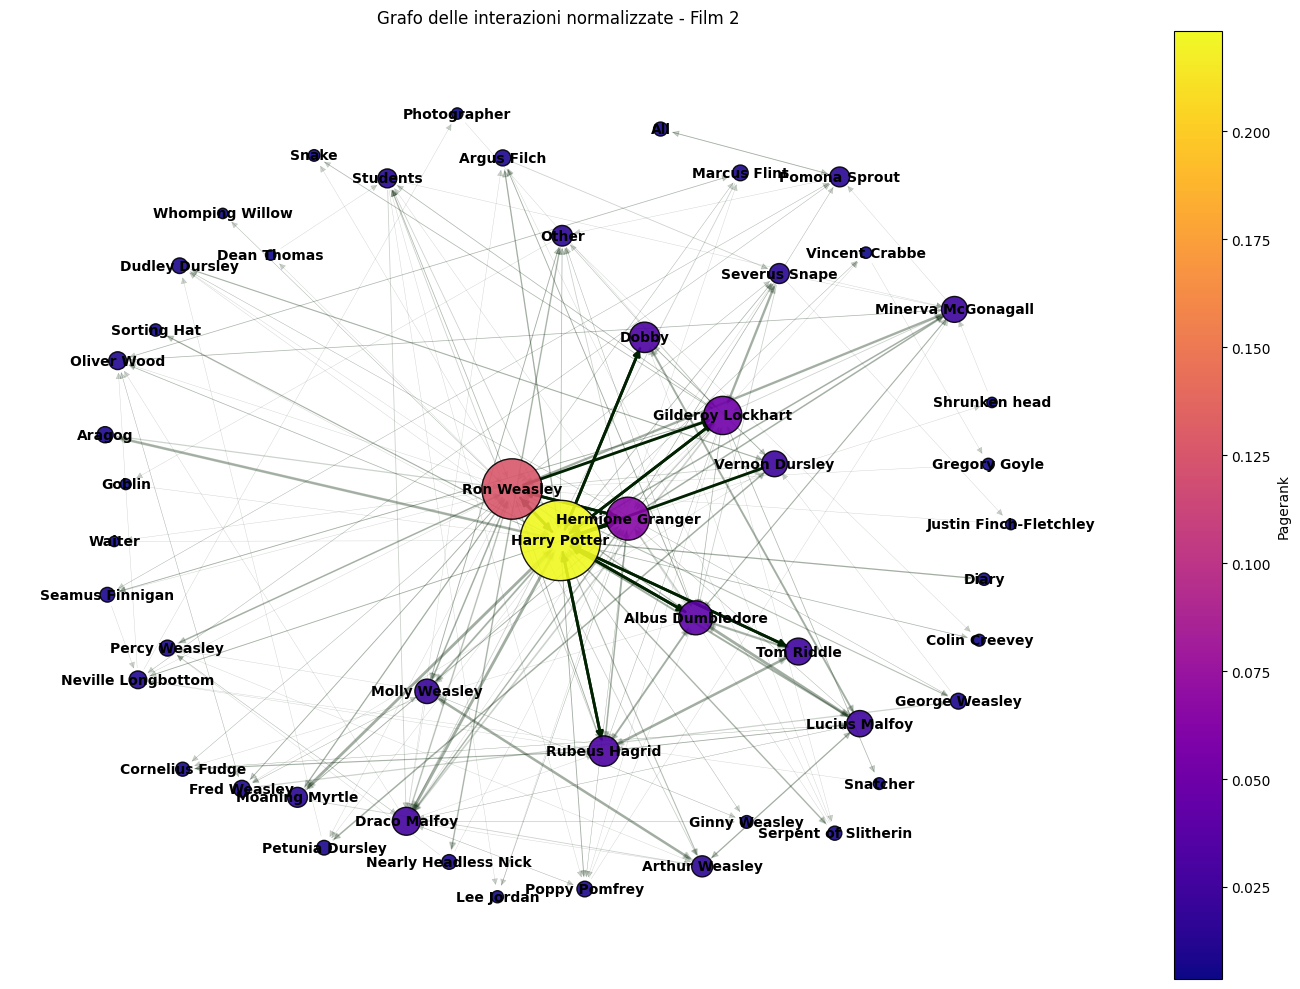

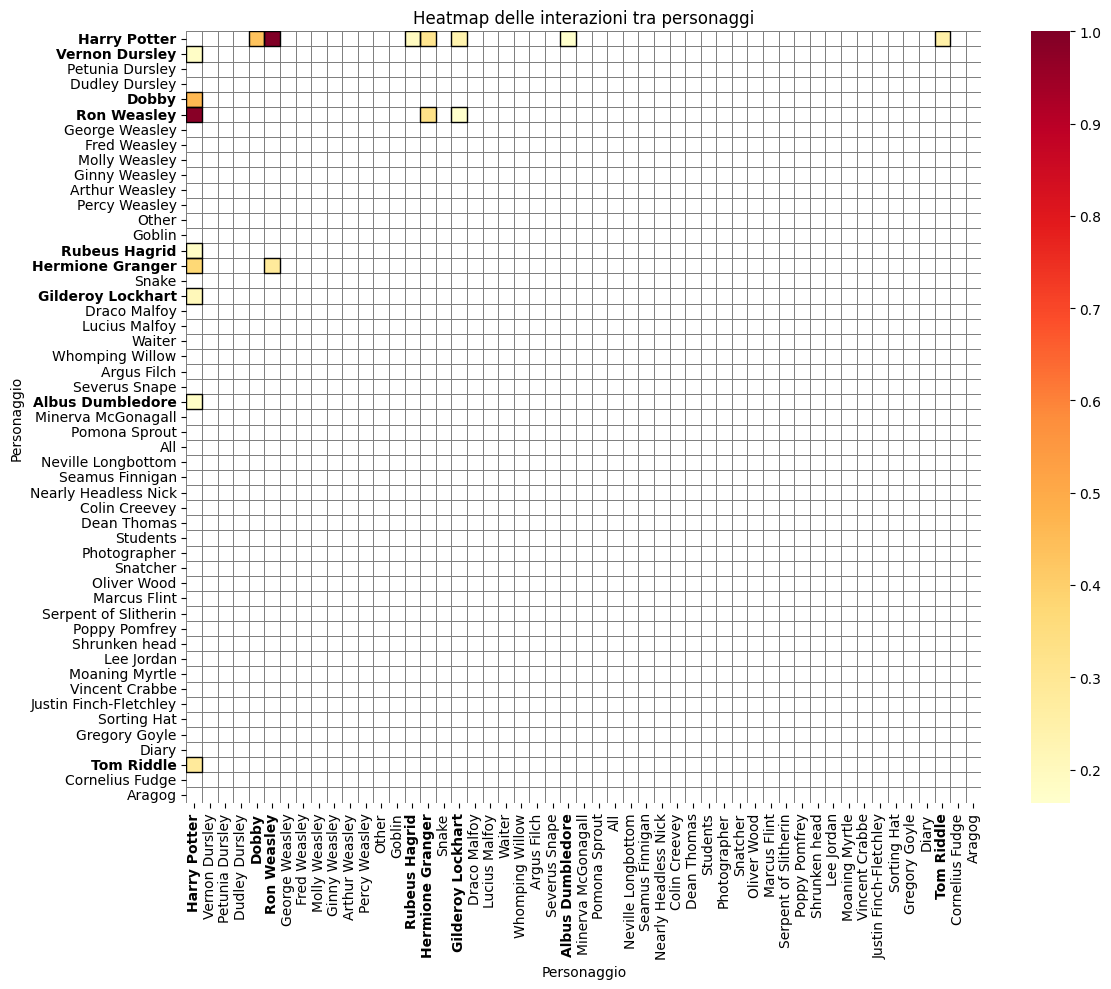

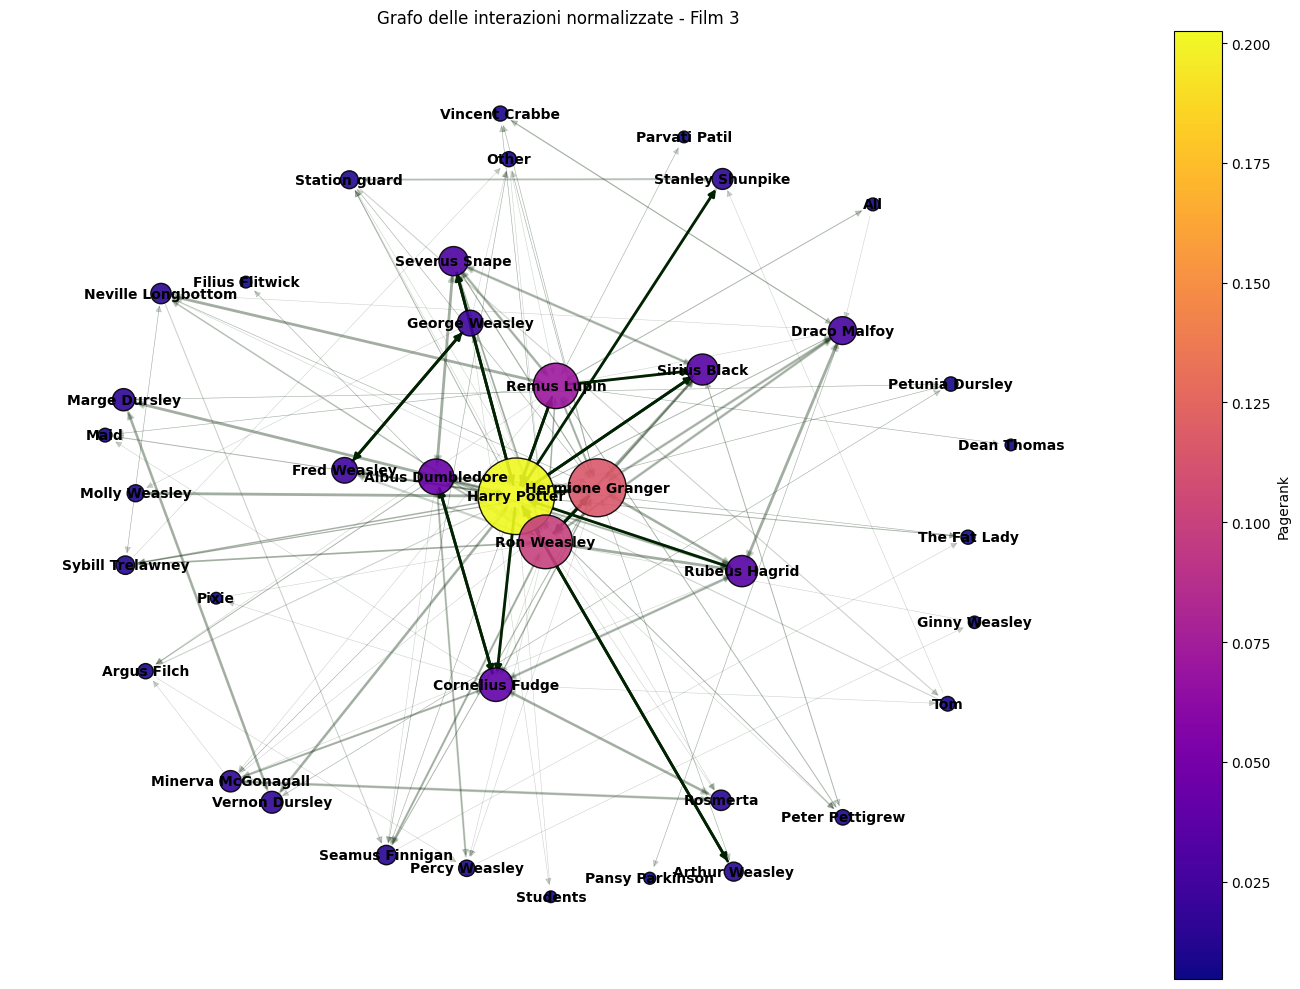

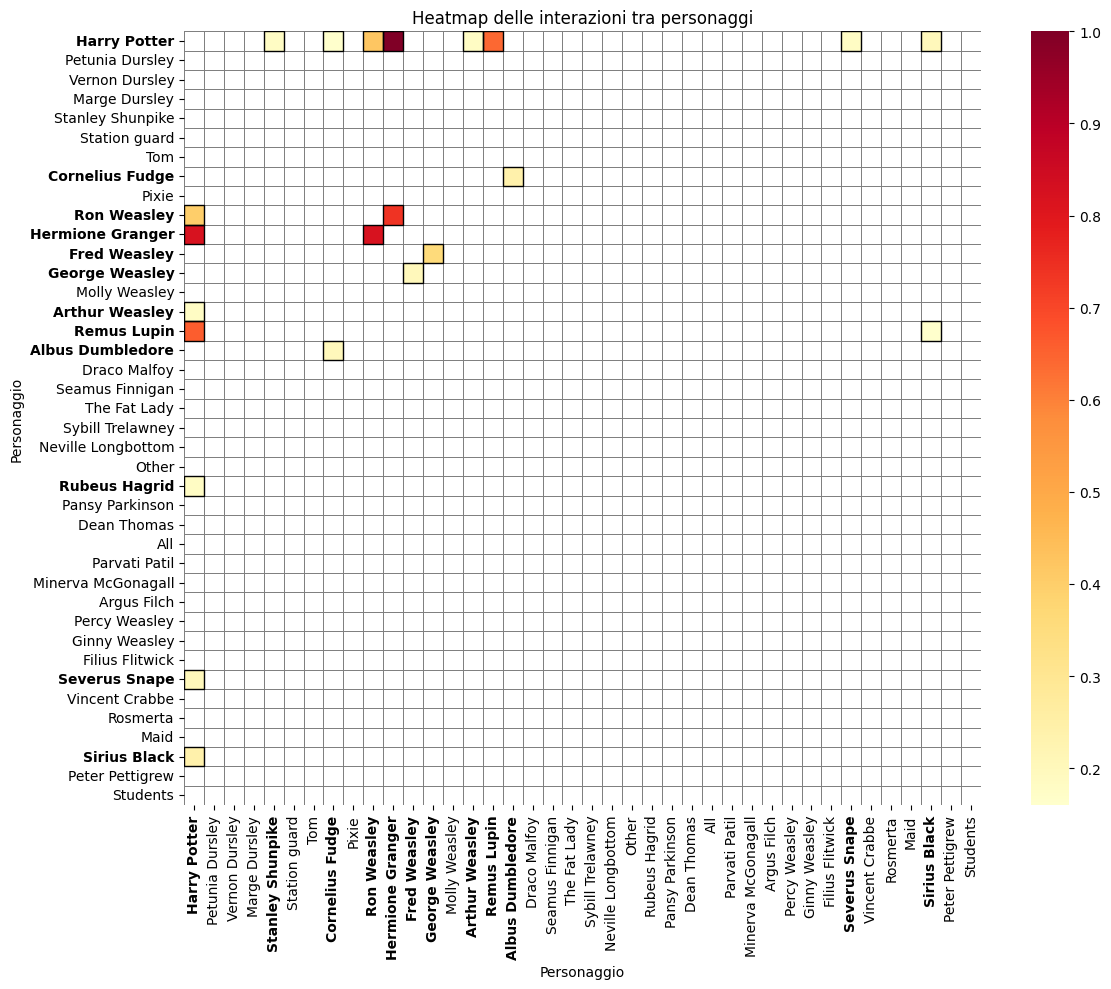

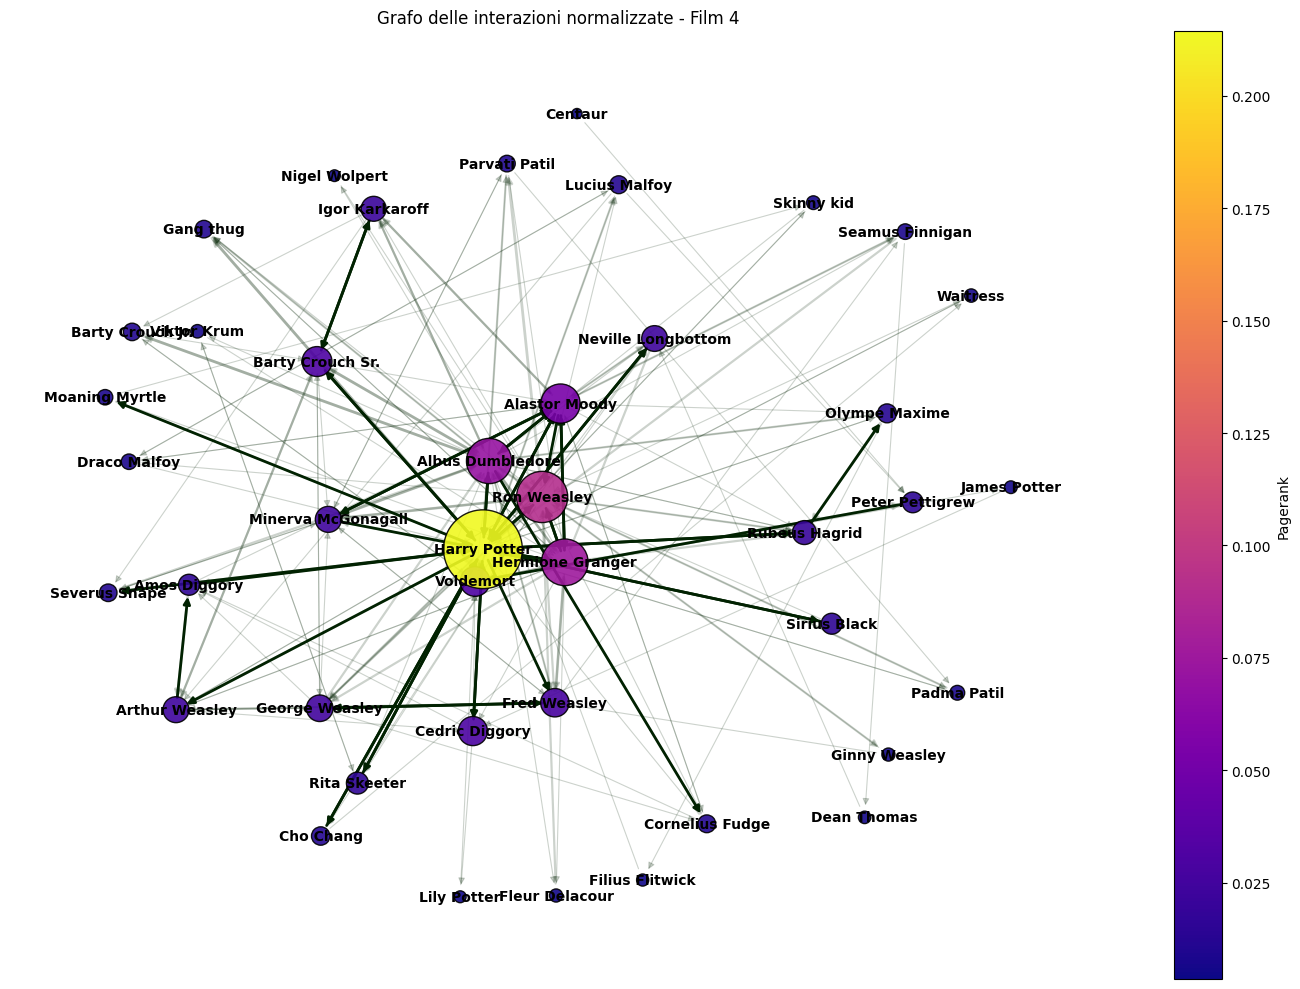

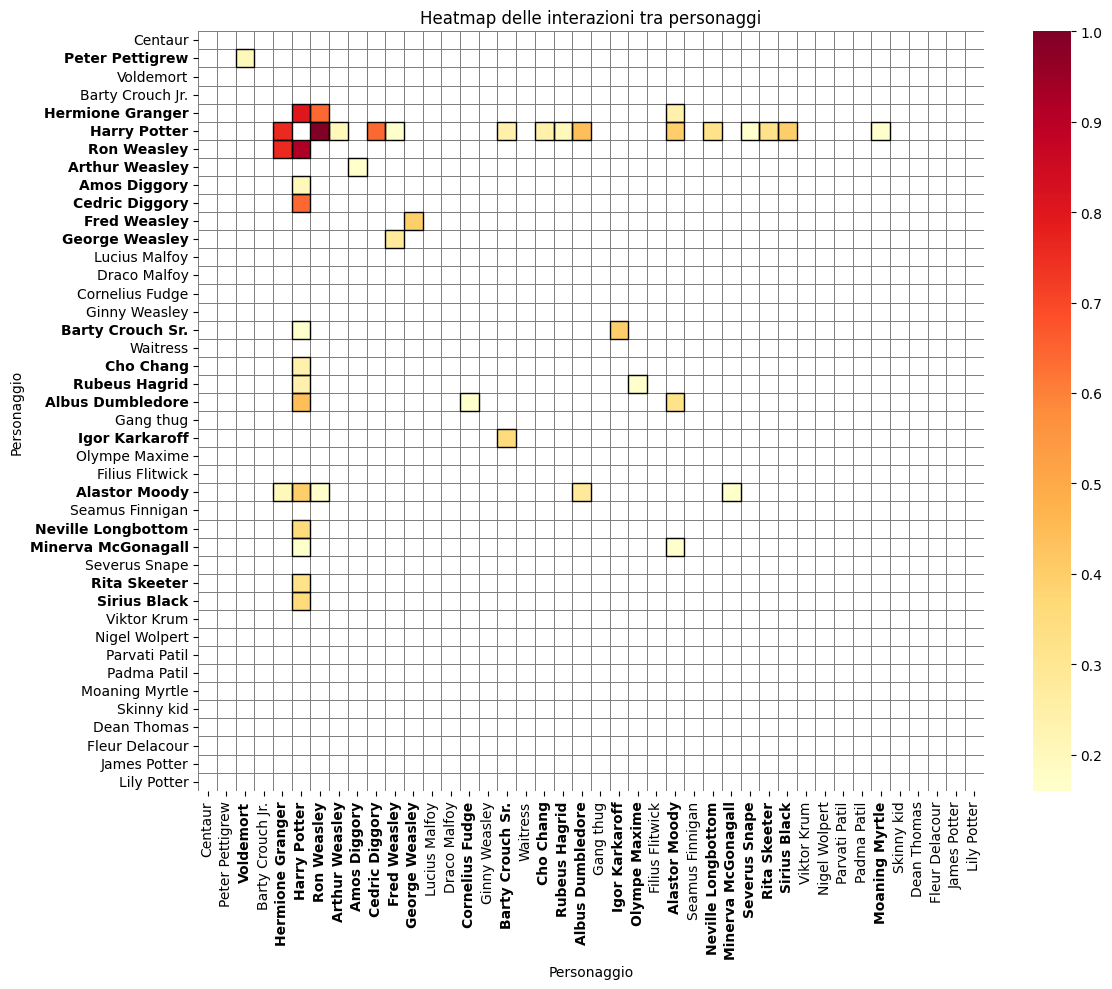

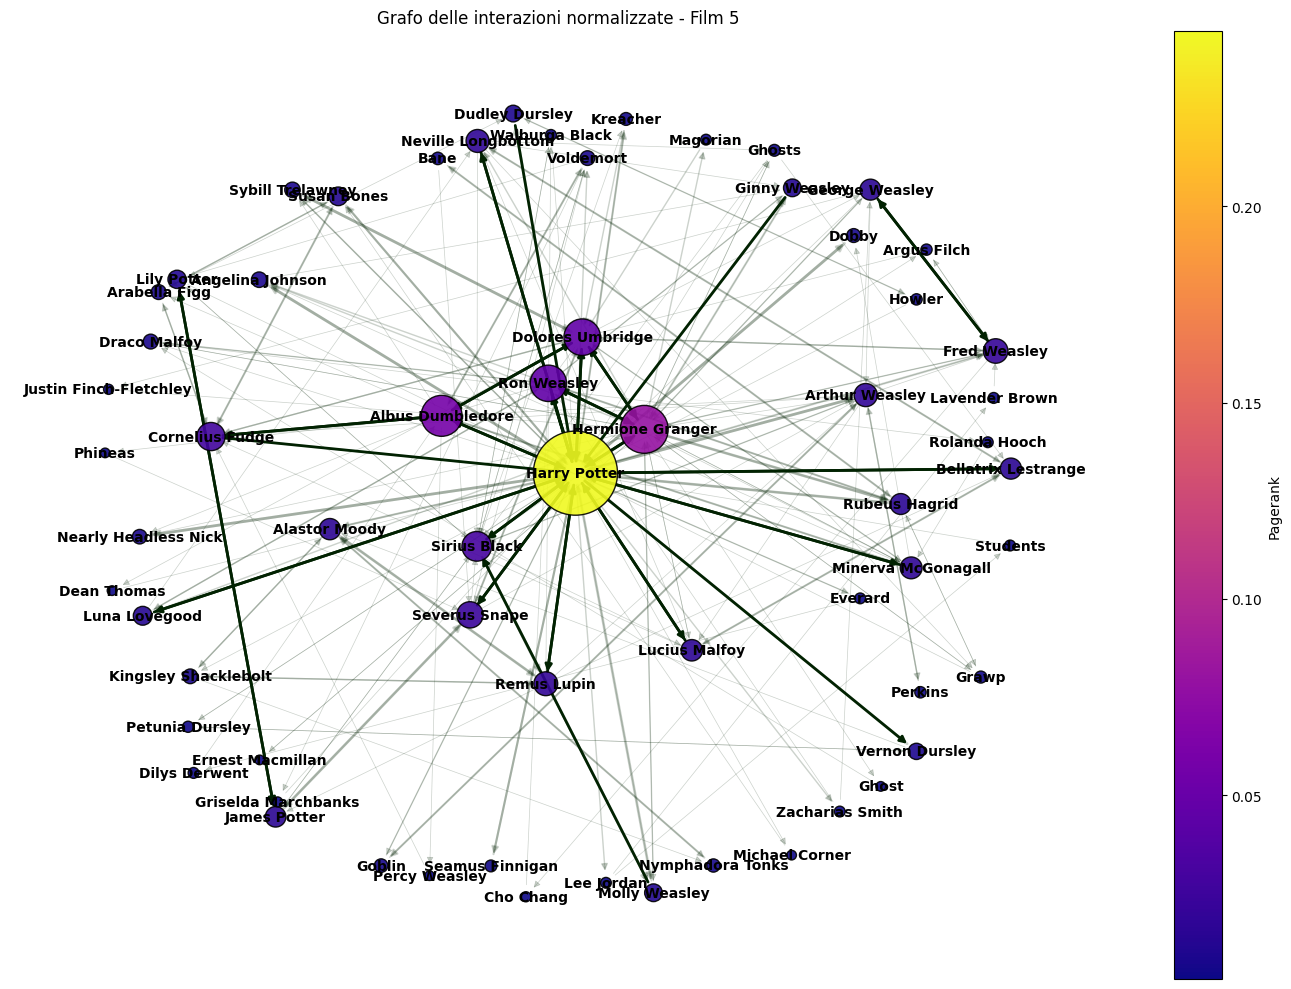

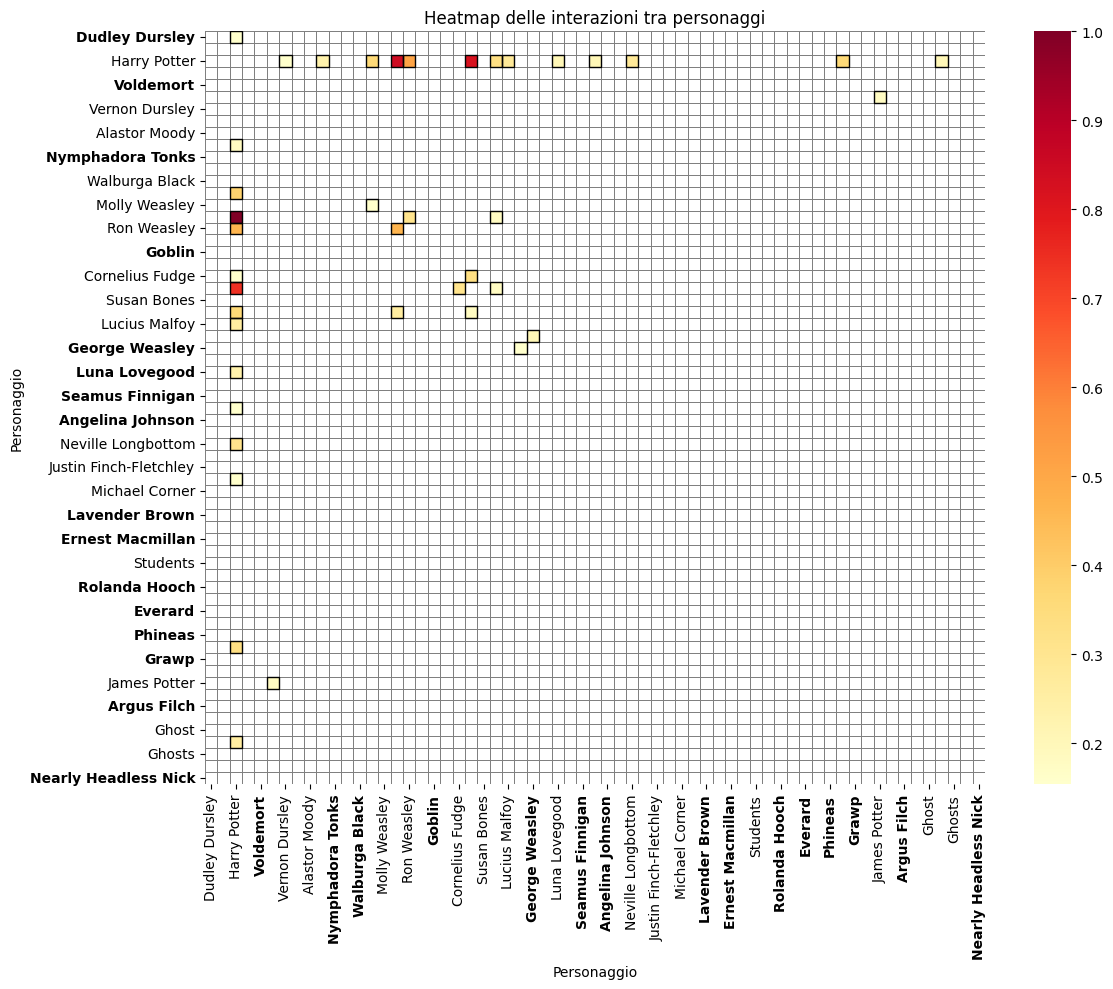

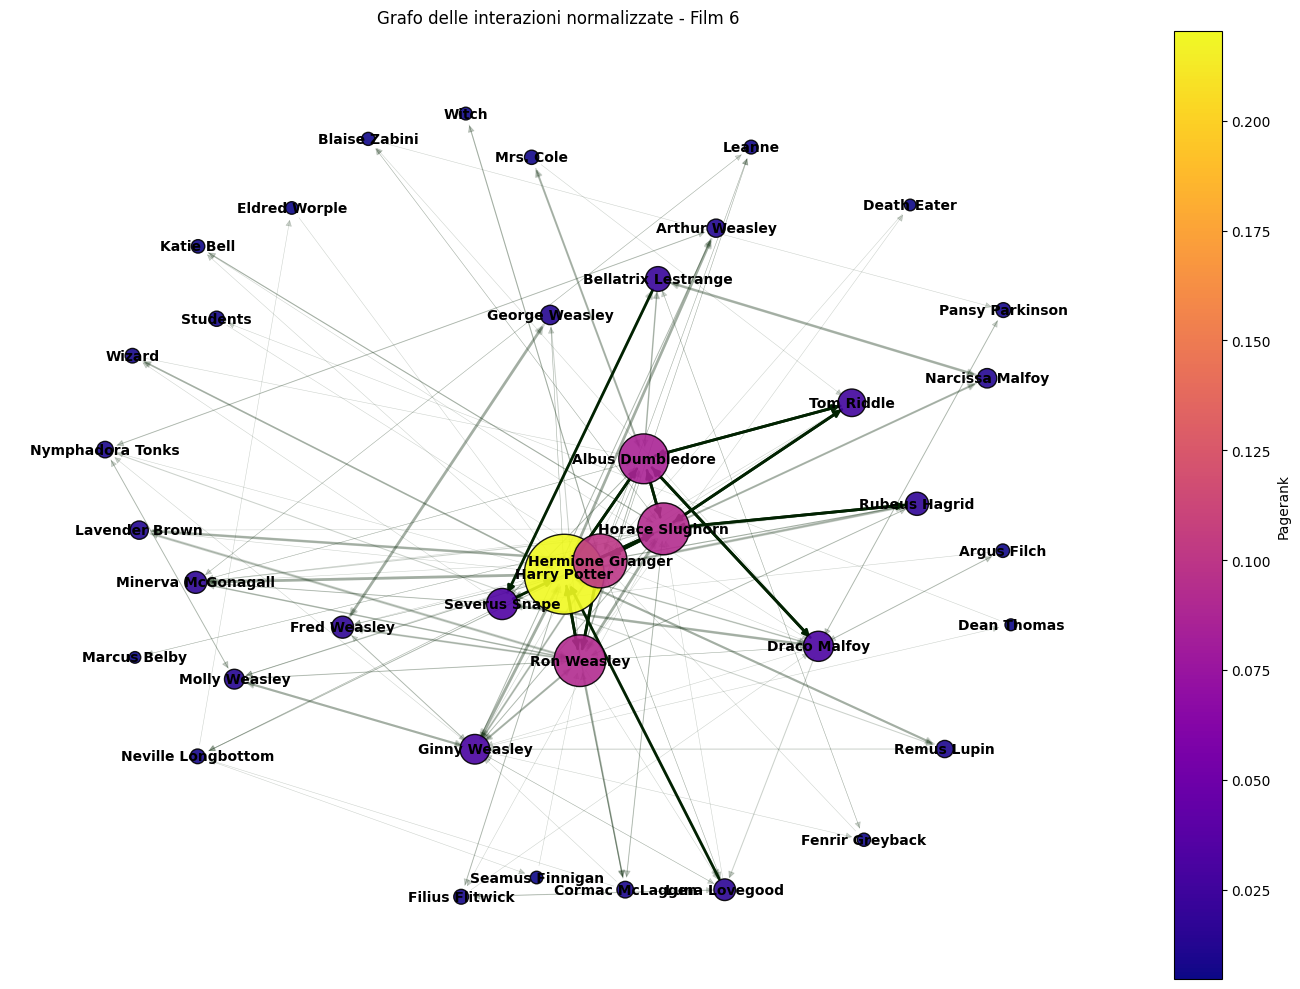

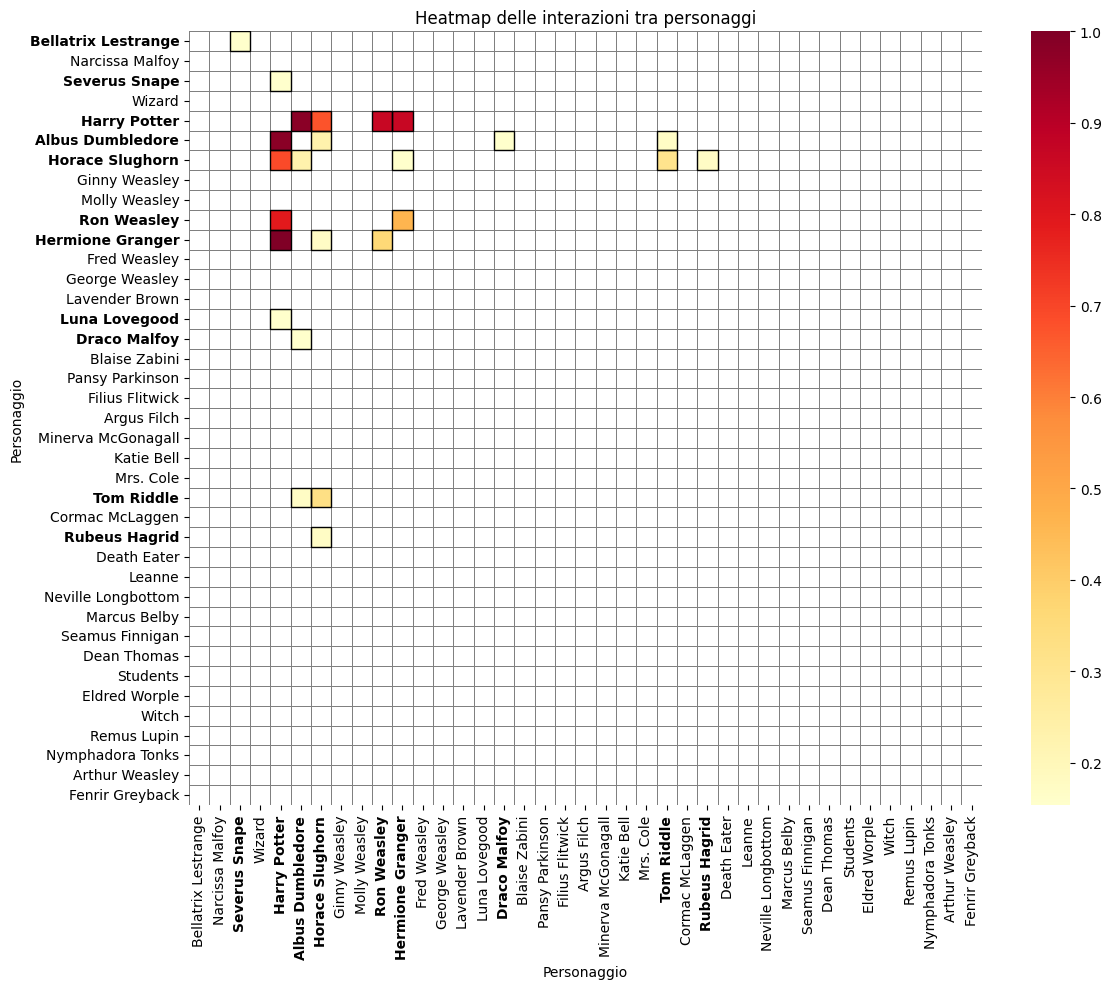

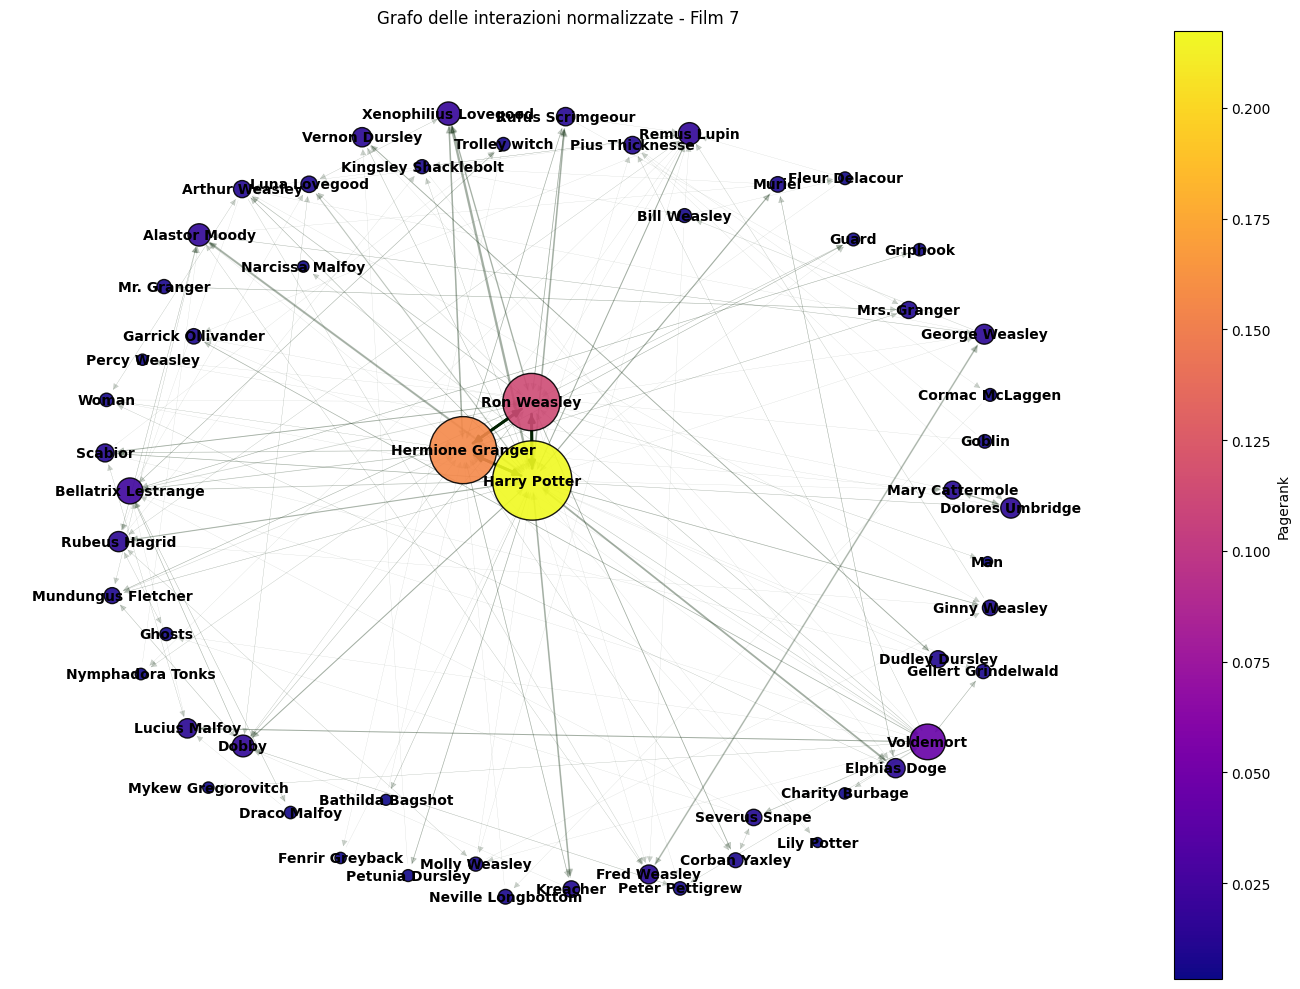

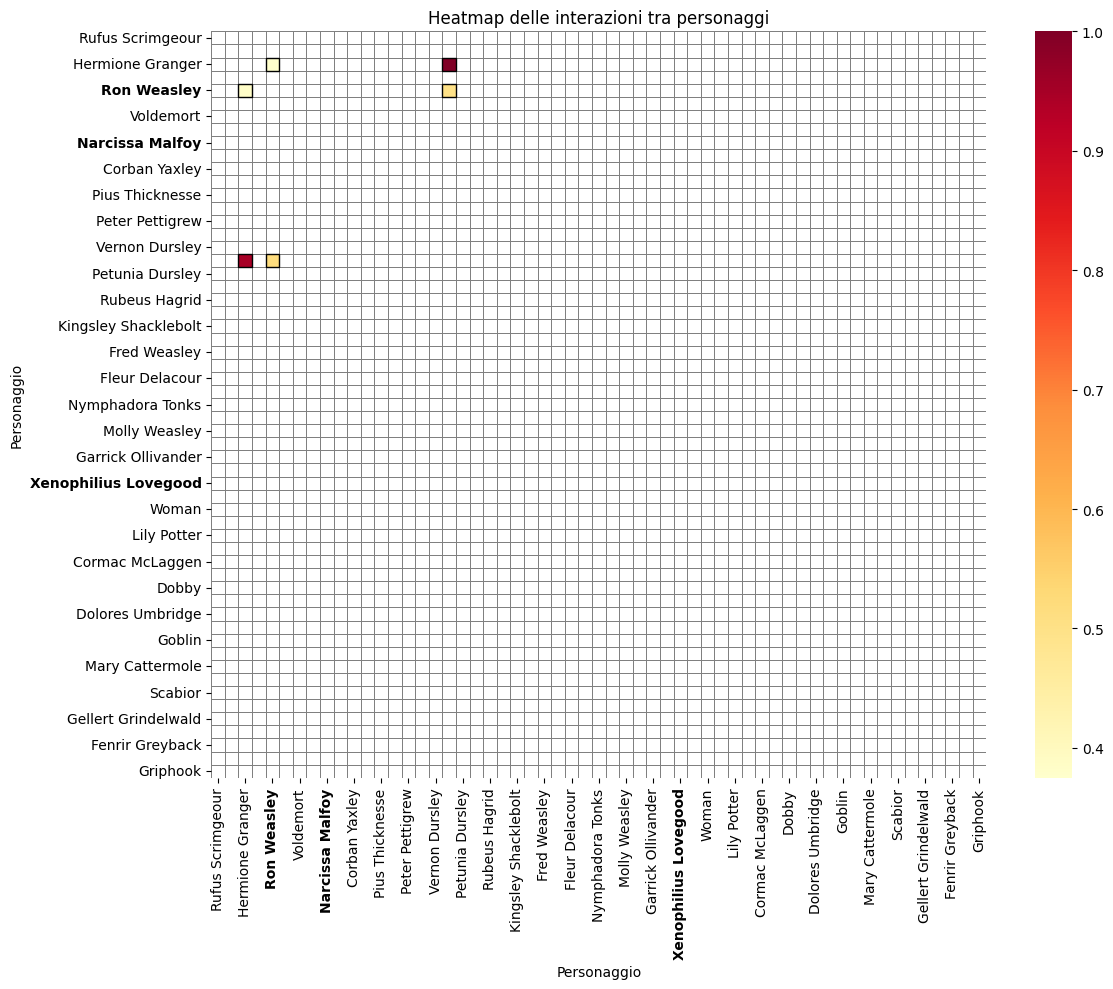

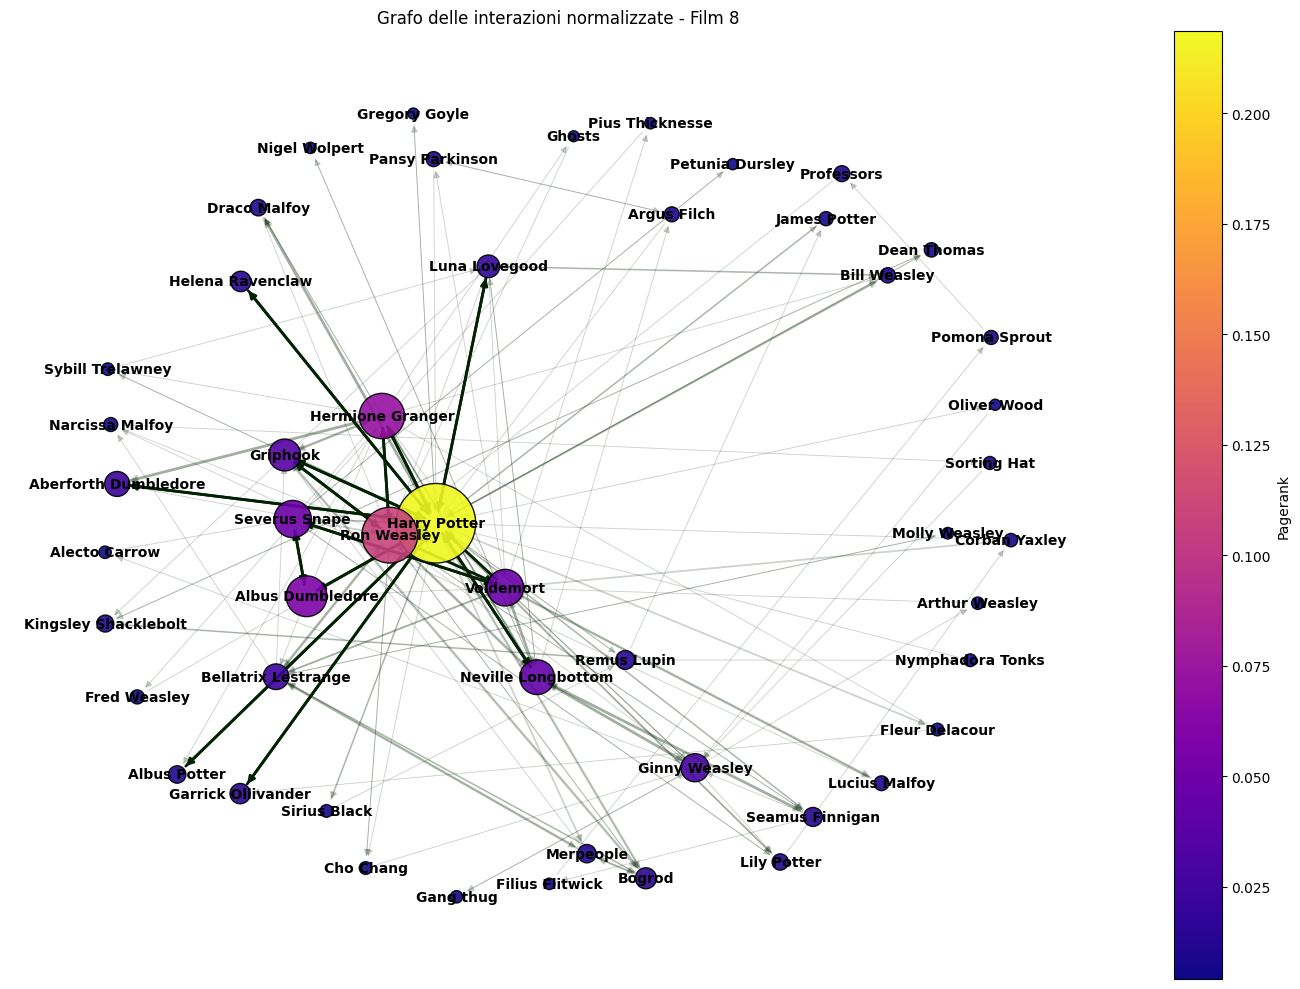

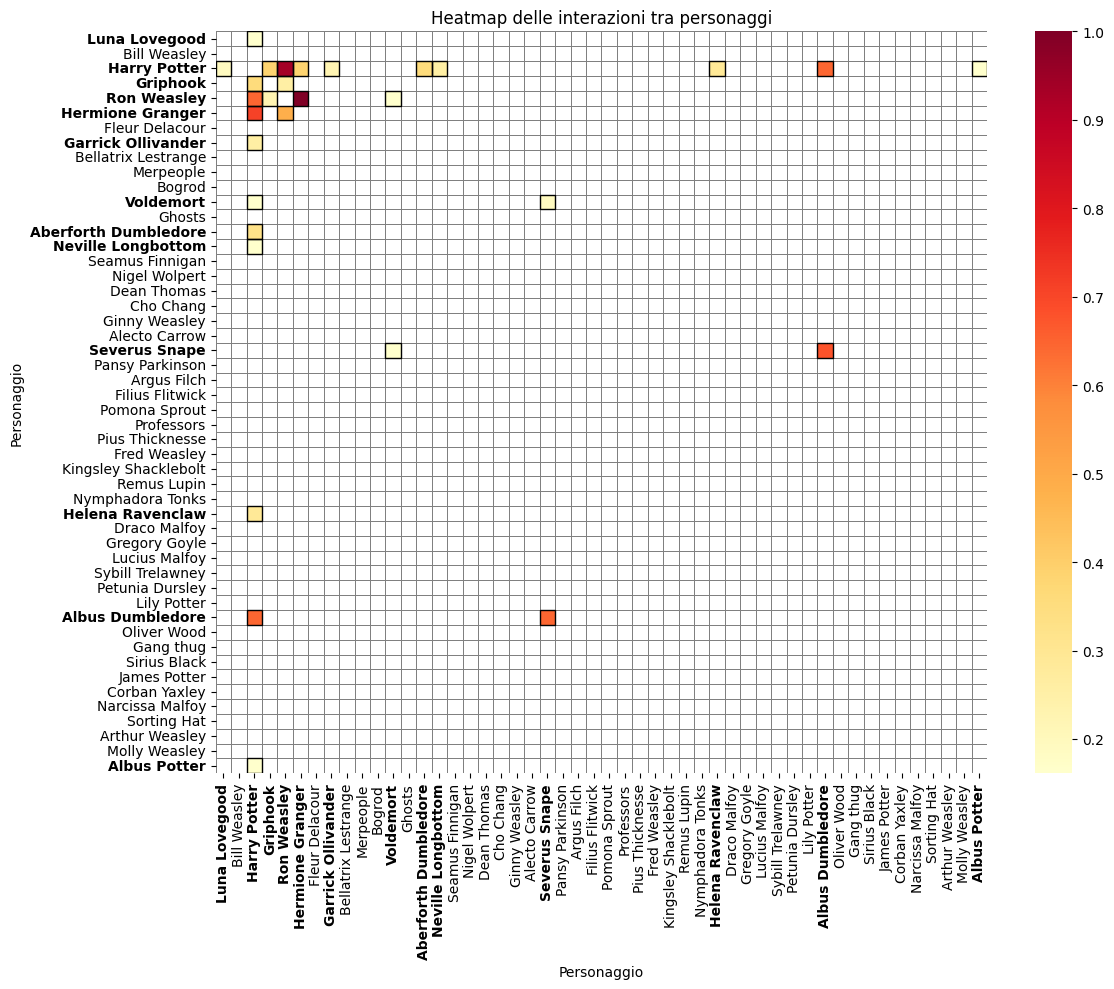

In [379]:
for i in range(1, 9):
  study_film(i, threshold=0.15) # giocare con la soglia di taglio

In [380]:
!pip install transformers
!pip install -q networkx pandas matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [381]:
from transformers import pipeline
import pandas as pd

# Campione
sample_dialogs = dialogs[['Dialogue']].dropna().drop_duplicates().sample(10, random_state=42).reset_index(drop=True)
sample_dialogs.columns = ['Dialogue']

# Modello funzionante
pipe = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion", top_k=1)

# Applica
results = []
for text in sample_dialogs['Dialogue']:
    try:
        result = pipe(text[:512])[0][0]  # CORRETTO: lista -> prima predizione
        label = result['label']
        score = round(result['score'], 3)
    except Exception as e:
        label, score = f"error ({str(e)})", 0.0
    results.append((label, score))

sample_dialogs["Emotion"] = [r[0] for r in results]
sample_dialogs["Score"] = [r[1] for r in results]

# Mostra risultati
pd.set_option("display.max_colwidth", None)
display(sample_dialogs)

RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

In [ ]:
from textblob import TextBlob

# Estrai polarità da ogni dialogo
dialogs["sentiment"] = dialogs["Dialogue"].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)


In [ ]:
centrality_sum = centrality_all.groupby('Character Name')['Betweenness'].sum().reset_index()
centrality_sum.columns = ['Character Name', 'Total Betweenness']

intensity = (
    dialogs.groupby("Character ID")["sentiment"]
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .rename(columns={
        'std': 'Emotional Intensity',
        'mean': 'Avg Sentiment',
        'count': 'Line Count'
    })
)

# Aggiungi il nome del personaggio
intensity = intensity.merge(characters[["Character ID", "Character Name"]], on="Character ID", how="left")

# Raggruppa le metriche di centralità
centrality_sum = centrality_all.groupby('Character Name')['Betweenness'].sum().reset_index()
centrality_sum.columns = ['Character Name', 'Total Betweenness']

# Unione tra emozione e centralità
summary = intensity.merge(centrality_sum, on='Character Name', how='left').fillna(0)

# Ordinamenti finali
top_emotional = summary.sort_values(by='Emotional Intensity', ascending=False).head(10)
least_central = summary.sort_values(by='Total Betweenness').head(10)

In [ ]:
dialogs.head()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

# --- PARAMETRI ---
ordered_titles = [
    "Philosopher's Stone",
    "Chamber of Secrets",
    "Prisoner of Azkaban",
    "Goblet of Fire",
    "Order of the Phoenix",
    "Half-Blood Prince",
    "Deathly Hallows – Part 1",
    "Deathly Hallows – Part 2"
]

title_map = {
    "Harry Potter and the Philosopher's Stone": "Philosopher's Stone",
    "Harry Potter and the Chamber of Secrets": "Chamber of Secrets",
    "Harry Potter and the Prisoner of Azkaban": "Prisoner of Azkaban",
    "Harry Potter and the Goblet of Fire": "Goblet of Fire",
    "Harry Potter and the Order of the Phoenix": "Order of the Phoenix",
    "Harry Potter and the Half-Blood Prince": "Half-Blood Prince",
    "Harry Potter and the Deathly Hallows Part 1": "Deathly Hallows – Part 1",
    "Harry Potter and the Deathly Hallows Part 2": "Deathly Hallows – Part 2"
}

# --- STEP 1: Preprocessing titoli film ---
dialogs = dialogs.drop(columns=['Betweenness', 'Centrality'], errors='ignore')
dialogs = dialogs.drop(columns=['Movie Title'], errors='ignore')
dialogs = dialogs.merge(movies[['Movie ID', 'Movie Title']], on='Movie ID', how='left')
dialogs['Movie Title'] = dialogs['Movie Title'].map(title_map)
dialogs['Movie Title'] = pd.Categorical(dialogs['Movie Title'], ordered=True, categories=ordered_titles)

# Normalizzazione nomi
dialogs['Character Name'] = dialogs['Character Name'].str.strip().str.lower()
summary['Character Name'] = summary['Character Name'].str.strip().str.lower()

# --- STEP 2: Selezione candidati ---
candidates = summary[
    (summary['Line Count'] >= 5) &
    (summary['Emotional Intensity'] >= 0.1) &
    (summary['Total Betweenness'] <= 0.05)
].copy()
candidates['Character Name'] = candidates['Character Name'].str.strip().str.lower()

print(f"Totale candidati iniziali: {len(summary)}")
print(f"Candidati dopo filtro EI e Betweenness: {len(candidates)}")

# --- STEP 3: Plot reali per ogni candidato ---
for name in candidates['Character Name']:
    char_dialogs = dialogs[dialogs['Character Name'] == name]
    if char_dialogs.empty:
        continue

    timeline = char_dialogs.groupby('Movie Title', observed=True)['sentiment'].sum().reindex(ordered_titles, fill_value=0)

    # Numero di film in cui ha battute
    num_film = (timeline != 0).sum()

    # --- GRAFICO ---
    plt.figure(figsize=(10, 4))
    plt.plot(timeline.index, timeline.values, marker='o', linestyle='-', label='Sentiment Totale')

    # PICCHI SOLO SE CI SONO VARIAZIONI
    if timeline.max() != timeline.min():
        max_idx = timeline.idxmax()
        min_idx = timeline.idxmin()
        if timeline[max_idx] != 0:
            plt.annotate("▲", xy=(max_idx, timeline[max_idx]), ha='center', va='bottom', fontsize=12, color='green')
        if timeline[min_idx] != 0 and min_idx != max_idx:
            plt.annotate("▼", xy=(min_idx, timeline[min_idx]), ha='center', va='top', fontsize=12, color='red')
    else:
        # spiegazione grafico piatto
        plt.text(0.5, 0.5, "Sentiment costante o neutro", transform=plt.gca().transAxes,
                 ha='center', va='center', fontsize=12, color='gray')

    plt.title(f"Evoluzione Emotiva: {name.title()} — {num_film} film")
    plt.xlabel("Film")
    plt.ylabel("Sentiment Totale")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    display(plt.gcf())
    plt.close()


## PARTE 2

In [ ]:
summary.head()

In [ ]:
dialogs.head()

In [ ]:
# Ora che i DataFrame summary e dialogs sono presenti, possiamo generare i pattern emotivi dettagliati

# Selezione dei personaggi centrali (in base alla betweenness)
central_characters = summary.sort_values(by='Total Betweenness', ascending=False).head(10).copy()
central_characters_names = central_characters['Character Name'].str.lower().tolist()

# Verifica colonna 'Emotion' nel DataFrame dialogs
has_emotion_column = 'Emotion' in dialogs.columns

# Se manca la colonna 'Emotion', aggiungiamo una colonna fittizia per evitare errore
if not has_emotion_column:
    dialogs['Emotion'] = 'unknown'

# Ordine coerente dei titoli
ordered_titles = [
    "Philosopher's Stone",
    "Chamber of Secrets",
    "Prisoner of Azkaban",
    "Goblet of Fire",
    "Order of the Phoenix",
    "Half-Blood Prince",
    "Deathly Hallows – Part 1",
    "Deathly Hallows – Part 2"
]

# Costruzione dei pattern per i personaggi centrali
detailed_features = []

for name in central_characters_names:
    char_dialogs = dialogs[dialogs['Character Name'].str.lower() == name]
    timeline = char_dialogs.groupby('Movie Title')['sentiment'].sum().reindex(ordered_titles, fill_value=0)

    mean_sent = timeline.mean()
    std_sent = timeline.std()
    max_val = timeline.max()
    min_val = timeline.min()
    max_idx = timeline.idxmax() if max_val != 0 else None
    min_idx = timeline.idxmin() if min_val != 0 else None
    films_present = (timeline != 0).sum()

    # Conta le emozioni (se presenti)
    emotion_counts = (
        char_dialogs['Emotion'].value_counts(normalize=True)
        .round(2).to_dict() if has_emotion_column else {}

    )

    detailed_features.append({
        'Character': name.title(),
        'Films Present': films_present,
        'Mean Sentiment': round(mean_sent, 3),
        'Sentiment Std': round(std_sent, 3),
        'Max Peak': round(max_val, 3),
        'Max Film': max_idx,
        'Min Dip': round(min_val, 3),
        'Min Film': min_idx,
        **emotion_counts
    })

# Output finale come DataFrame
detailed_df = pd.DataFrame(detailed_features).fillna(0)
display(detailed_df)



In [ ]:
import matplotlib.pyplot as plt

# Ordine corretto dei film
ordered_titles = [
    "Philosopher's Stone", "Chamber of Secrets", "Prisoner of Azkaban",
    "Goblet of Fire", "Order of the Phoenix", "Half-Blood Prince",
    "Deathly Hallows – Part 1", "Deathly Hallows – Part 2"
]

# Visualizza grafici per ciascun personaggio
for name in central_characters_names:
    char_dialogs = dialogs[dialogs['Character Name'].str.lower() == name]

    timeline = char_dialogs.groupby('Movie Title')['sentiment'].sum().reindex(ordered_titles, fill_value=0)
    films_present = (timeline != 0).sum()

    # Crea figura
    plt.figure(figsize=(10, 4))
    plt.plot(timeline.index, timeline.values, marker='o', label='Sentiment Totale')
    plt.axhline(0, linestyle='--', color='gray', linewidth=0.8)

    # Annotazioni
    max_val = timeline.max()
    min_val = timeline.min()
    if max_val != 0:
        max_idx = timeline.idxmax()
        plt.annotate("▲", xy=(max_idx, max_val), ha='center', va='bottom', fontsize=12, color='green')
    if min_val != 0:
        min_idx = timeline.idxmin()
        plt.annotate("▼", xy=(min_idx, min_val), ha='center', va='top', fontsize=12, color='red')

    # Titolo e info
    plt.title(f"{name.title()} – Presente in {films_present} film")
    plt.xlabel("Film")
    plt.ylabel("Sentiment Totale")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
from transformers import pipeline
from tqdm import tqdm

pipe = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion", top_k=1)

def classify_emotion(text):
    try:
        result = pipe(str(text)[:512])[0][0]
        return result['label']
    except:
        return 'unknown'

# Solo se non presente
if 'Emotion' not in dialogs.columns or dialogs['Emotion'].eq('unknown').all():
    tqdm.pandas()
    dialogs['Emotion'] = dialogs['Dialogue'].progress_apply(classify_emotion)


In [ ]:
# Assicura coerenza con titoli
dialogs['Movie Title'] = pd.Categorical(dialogs['Movie Title'], ordered=True, categories=ordered_titles)

# Raggruppa e conta emozioni
dominant_emotions = (
    dialogs.groupby(['Character Name', 'Movie Title'])['Emotion']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)

# Pivot per heatmap
emotion_pivot = dominant_emotions.pivot(index='Character Name', columns='Movie Title', values='Emotion')


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Mappa delle emozioni a colori
emotion_palette = {
    'joy': '#FFD700',       # giallo
    'anger': '#FF4500',     # rosso
    'sadness': '#1E90FF',   # blu
    'fear': '#8A2BE2',      # viola
    'love': '#FF69B4',      # rosa
    'surprise': '#FFA500',  # arancione
    'unknown': '#D3D3D3'    # grigio
}

# Riempi i NaN con 'unknown' per sicurezza
emotion_pivot_filled = emotion_pivot.fillna('unknown')

# Crea matrice numerica dummy
numeric_matrix = np.ones_like(emotion_pivot_filled.values, dtype=float)

# Costruisci matrice di colori (usando la palette)
color_matrix = emotion_pivot_filled.copy()
for emotion, color in emotion_palette.items():
    color_matrix = color_matrix.replace(emotion, color)

# Plot heatmap
plt.figure(figsize=(14, 10))
ax = sns.heatmap(
    numeric_matrix,
    annot=emotion_pivot_filled.values,
    fmt="",
    cmap=["white"],  # serve un valore placeholder, verrà sovrascritto
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    xticklabels=emotion_pivot.columns,
    yticklabels=emotion_pivot.index,
    annot_kws={"size": 12, "weight": "bold", "color": "black"}
)

# Applica colore di sfondo cella per cella
for y in range(color_matrix.shape[0]):
    for x in range(color_matrix.shape[1]):
        cell_color = color_matrix.iat[y, x]
        ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=True, color=cell_color, ec='gray'))

plt.title("Emozione Dominante per Personaggio e Film", fontsize=16)
plt.xlabel("Film")
plt.ylabel("Personaggio")
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Seleziona i 10 personaggi più centrali
top_central = summary.sort_values(by='Total Betweenness', ascending=False).head(10)
central_names = top_central['Character Name'].str.lower().tolist()
# Filtra i dialoghi per i personaggi centrali
central_dialogs = dialogs[dialogs['Character Name'].str.lower().isin(central_names)]

# Raggruppa per personaggio e film, trova emozione dominante
dominant_emotions = (
    central_dialogs.groupby(['Character Name', 'Movie Title'])['Emotion']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)

# Pivot: righe = personaggi, colonne = film
emotion_pivot = dominant_emotions.pivot(index='Character Name', columns='Movie Title', values='Emotion')
# Mappa colori per emozioni
emotion_palette = {
    'joy': '#FFD700',
    'anger': '#FF4500',
    'sadness': '#1E90FF',
    'fear': '#8A2BE2',
    'love': '#FF69B4',
    'surprise': '#FFA500',
    'unknown': '#D3D3D3'
}

# Riempi NaN
emotion_pivot_filled = emotion_pivot.fillna('unknown')

# Matrice dummy
numeric_matrix = np.ones_like(emotion_pivot_filled.values, dtype=float)

# Matrice colori
color_matrix = emotion_pivot_filled.copy()
for emotion, color in emotion_palette.items():
    color_matrix = color_matrix.replace(emotion, color)

# Plot
plt.figure(figsize=(14, 10))
ax = sns.heatmap(
    numeric_matrix,
    annot=emotion_pivot_filled.values,
    fmt="",
    cmap=["white"],
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    xticklabels=emotion_pivot.columns,
    yticklabels=emotion_pivot.index,
    annot_kws={"size": 12, "weight": "bold", "color": "black"}
)

# Colora manualmente le celle
for y in range(color_matrix.shape[0]):
    for x in range(color_matrix.shape[1]):
        cell_color = color_matrix.iat[y, x]
        ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=True, color=cell_color, ec='gray'))

plt.title("Emozione Dominante per i Personaggi più Centrali", fontsize=16)
plt.xlabel("Film")
plt.ylabel("Personaggio")
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
print(dialogs.columns.tolist())


In [ ]:
# Crea una colonna combinata: "Chap 05 – Film"
dialogs['Chapter Label'] = dialogs.apply(
    lambda row: f"Chap {int(row['Chapter ID']):02d} – {row['Movie Title']}" if pd.notnull(row['Chapter ID']) else None,
    axis=1
)
central_dialogs = dialogs[dialogs['Character Name'].str.lower().isin(central_names)].copy()
# Gruppo per personaggio e capitolo
dominant_by_chapter = (
    central_dialogs
    .dropna(subset=['Chapter Label'])
    .groupby(['Character Name', 'Chapter Label'])['Emotion']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)

# Pivot: righe = personaggi, colonne = capitoli
chapter_pivot = dominant_by_chapter.pivot(index='Character Name', columns='Chapter Label', values='Emotion')

ordered_titles = [
    "Philosopher's Stone",
    "Chamber of Secrets",
    "Prisoner of Azkaban",
    "Goblet of Fire",
    "Order of the Phoenix",
    "Half-Blood Prince",
    "Deathly Hallows – Part 1",
    "Deathly Hallows – Part 2"
]

# Ordina colonne (capitoli) nel giusto ordine cronologico
# Ordina le colonne in base a:
# 1. Ordine del film
# 2. Numero del capitolo
def sort_key(col_label):
    try:
        # Trova il titolo del film matchando da lista
        matched_title = next(title for title in ordered_titles if title in col_label)
        movie_index = ordered_titles.index(matched_title)
        chapter_num = int(col_label.split(" ")[1])  # estrae 205 da "Chap 205 – ..."
        return (movie_index, chapter_num)
    except Exception as e:
        print(f"Errore parsing colonna: {col_label} — {e}")
        return (999, 999)


chapter_order = sorted(chapter_pivot.columns, key=sort_key)
chapter_pivot = chapter_pivot[chapter_order]

# Palette colori
emotion_palette = {
    'joy': '#FFD700',
    'anger': '#FF4500',
    'sadness': '#1E90FF',
    'fear': '#8A2BE2',
    'love': '#FF69B4',
    'surprise': '#FFA500',
    'unknown': '#D3D3D3'
}

# Riempi i NaN
chapter_pivot_filled = chapter_pivot.fillna('unknown')
numeric_matrix = np.ones_like(chapter_pivot_filled.values, dtype=float)

# Mappa colori
color_matrix = chapter_pivot_filled.copy()
for emotion, color in emotion_palette.items():
    color_matrix = color_matrix.replace(emotion, color)

# Plot
plt.figure(figsize=(18, 10))  # Larghezza maggiore per tanti capitoli
ax = sns.heatmap(
    numeric_matrix,
    annot=chapter_pivot_filled.values,
    fmt="",
    cmap=["white"],
    cbar=False,
    linewidths=0.3,
    linecolor='gray',
    xticklabels=chapter_pivot.columns,
    yticklabels=chapter_pivot.index,
    annot_kws={"size": 10, "weight": "bold", "color": "black"}
)

# Colora le celle manualmente
for y in range(color_matrix.shape[0]):
    for x in range(color_matrix.shape[1]):
        cell_color = color_matrix.iat[y, x]
        ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=True, color=cell_color, ec='gray'))

plt.title("Emozione Dominante per Capitolo — Personaggi più Centrali", fontsize=16)
plt.xlabel("Capitolo (con Film)")
plt.ylabel("Personaggio")
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
